# CosmoDC realizations
## Dependencies

In [7]:
import os
import numpy as np
import pandas as pd
import random
import scipy
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import h5py
%matplotlib inline

In [8]:
import GCRCatalogs
from GCR import GCRQuery

## Script form

In [9]:
# Load CosmoDC2
cat = GCRCatalogs.load_catalog('CosmoDC2_v1.1.4_image_with_photozs_v1')
zgrid = cat.photoz_pdf_bin_centers


In [10]:
# Load Judit's catalog
fname = "/global/cfs/cdirs/lsst/groups/WL/projects/star-challenge/cosmodc2/TXPipe-full-output/binned_shear_catalog.hdf5"
hf = h5py.File(fname, "r")

In [ ]:
# Load cat 
photo_cat = cat.get_quantities(['galaxy_id', 'photoz_pdf'],
                   return_iterator=True)
basic_cuts = [GCRQuery('photoz_mask==1')]

# Assign to tomo bins and save
save_to = "/pscratch/sd/j/jaimerz/CosmoDC2_catalogs/shear_tracks"
for i, photo_q in enumerate(photo_cat):
    candidate_fname = save_to+"/shear_0_{}".format(i)
    if os.path.isfile(candidate_fname):
        pass
    else:
        ids = photo_q['galaxy_id']
        sel_0 = np.isin(ids, hf["shear"]["bin_0"]["id"])
        sel_1 = np.isin(ids, hf["shear"]["bin_1"]["id"])
        sel_2 = np.isin(ids, hf["shear"]["bin_2"]["id"])
        sel_3 = np.isin(ids, hf["shear"]["bin_3"]["id"])
        sel_4 = np.isin(ids, hf["shear"]["bin_4"]["id"])
        id_0 = ids[sel_0]
        id_1 = ids[sel_1]
        id_2 = ids[sel_2]
        id_3 = ids[sel_3]
        id_4 = ids[sel_4]
        photoz_0 = list(photo_q['photoz_pdf'][sel_0])
        photoz_1 = list(photo_q['photoz_pdf'][sel_1])
        photoz_2 = list(photo_q['photoz_pdf'][sel_2])
        photoz_3 = list(photo_q['photoz_pdf'][sel_3])
        photoz_4 = list(photo_q['photoz_pdf'][sel_4])
        
        #pzdict_0 = {'id': id_0, 'pdf': photoz_0}
        #pzdict_1 = {'id': id_1, 'pdf': photoz_1}
        #pzdict_2 = {'id': id_2, 'pdf': photoz_2}
        #pzdict_3 = {'id': id_3, 'pdf': photoz_3}
        #pzdict_4 = {'id': id_4, 'pdf': photoz_4}
        
        fname_0 = save_to+"/shear_0_{}".format(i)
        fname_1 = save_to+"/shear_1_{}".format(i)
        fname_2 = save_to+"/shear_2_{}".format(i)
        fname_3 = save_to+"/shear_3_{}".format(i)
        fname_4 = save_to+"/shear_4_{}".format(i)
        
        np.savez(fname_0, ids=id_0, pdf=photoz_0)
        np.savez(fname_1, ids=id_1, pdf=photoz_1)
        np.savez(fname_2, ids=id_2, pdf=photoz_2)
        np.savez(fname_3, ids=id_3, pdf=photoz_3)
        np.savez(fname_4, ids=id_4, pdf=photoz_4)

        print(i, len(id_0), len(id_1), len(id_2), 
             len(id_3), len(id_4), end='\r', flush=True)

In [4]:
load_from = "/pscratch/sd/j/jaimerz/CosmoDC2_catalogs/shear_tracks"
save_to = "/pscratch/sd/j/jaimerz/CosmoDC2_catalogs/shear"

for tomo_bin in np.arange(0, 5):
    tomo_name = "/shear_{}.npz".format(tomo_bin)
    tomo_path = save_to+tomo_name
    if os.path.isfile(tomo_path):
        pass
    else:
        print(tomo_bin)
        track = 0
        candidate_file = load_from+"/shear_{}_{}.npz".format(tomo_bin, track)
        total_ids = np.array([])
        total_pdfs = list([])
        while os.path.isfile(candidate_file):
            pzdict = dict(np.load(candidate_file, allow_pickle=True))
            ids = pzdict['ids']
            pdfs = pzdict['pdf']
            total_ids = np.append(total_ids, ids)
            for pdf in pdfs:
                total_pdfs.append(pdf)
            print((track, len(total_ids)), end='\r', flush=True)
            track = track + 1
            candidate_file = load_from+"/shear_{}_{}.npz".format(tomo_bin, track)
        tomo = {'ids': total_ids, 'pdfs':total_pdfs}
        np.savez(tomo_path, ids=total_ids, pdfs=total_pdfs)


0
1392, 4499915)
2392, 4528721)
3392, 5276075)
4392, 7875728)


In [11]:
grids = [[0.0, 0.7],
         [0.0, 0.8],
         [0.15, 1.15],
         [0.3, 1.4],
         [0.5, 2.0]]
load_from = "/pscratch/sd/j/jaimerz/CosmoDC2_catalogs/shear"
save_to = "/pscratch/sd/j/jaimerz/CosmoDC2_catalogs/shear_samples"

def make_realizations(load_from, save_to, grids,
                   normalize=False, n_samples=1_000):
    rs = np.array([np.random.uniform() for i in np.arange(n_samples)])
    for i, grid in enumerate(grids):
        candidate_fname = save_to+"/shear_{}.npz".format(i)
        if os.path.isfile(candidate_fname):
            pass
        else:
            print(i)
            tomo_name = "/shear_{}.npz".format(i)
            tomo = np.load(load_from+tomo_name, allow_pickle=True)
            pdfs = np.array(tomo['pdfs'])
            print("Generate samples")
            photo_samples = []
            for j, pdf in enumerate(pdfs):
                if j % 100 == 0:
                    print(j, end='\r', flush=True)
                norm = np.sum(pdf)
                if normalize:
                    pdf = pdf/norm
                cdf = np.cumsum(pdf)
                cdf_i = interp1d(cdf, zgrid, fill_value="extrapolate")
                photo_samples.append(cdf_i(rs))
            photo_samples = np.array(photo_samples)

            print("Make histograms out of samples")
            zbins = np.linspace(grid[0],grid[1], 26)
            znodes = 0.5*(zbins[1:]+zbins[:-1])
            photo_hists = []
            for j, samples in enumerate(photo_samples.T):
                print(j, end='\r', flush=True)
                photo_hist = np.histogram(samples, bins=zbins, density=False)[0]
                photo_hists.append(photo_hist)
            photo_hists = np.array(photo_hists)
            if normalize:
                photo_hists_norms = np.array([np.sum(hist) for hist in photo_hists])
                photo_hists = photo_hists.T/photo_hists_norms
            else:
                photo_hists = photo_hists.T
            np.savez(candidate_fname,
                     zgrid=zbins,
                     znodes=znodes,
                     photo_hists=photo_hists)

In [ ]:
make_realizations(load_from, save_to, grids)

2
Generate samples


/global/common/software/lsst/gitlab/desc-python-prod/2024-03-04-26-36/py/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Make histograms out of samples
3
Generate samples
Make histograms out of samples
4
Generate samples
Make histograms out of samples


In [22]:
shear_0 = np.load("/pscratch/sd/j/jaimerz/CosmoDC2_catalogs/shear_samples/shear_0.npz", allow_pickle=True)
shear_1 = np.load("/pscratch/sd/j/jaimerz/CosmoDC2_catalogs/shear_samples/shear_1.npz", allow_pickle=True)
shear_2 = np.load("/pscratch/sd/j/jaimerz/CosmoDC2_catalogs/shear_samples/shear_2.npz", allow_pickle=True)
shear_3 = np.load("/pscratch/sd/j/jaimerz/CosmoDC2_catalogs/shear_samples/shear_3.npz", allow_pickle=True)
shear_4 = np.load("/pscratch/sd/j/jaimerz/CosmoDC2_catalogs/shear_samples/shear_4.npz", allow_pickle=True)

shears = {'shear_0': shear_0,
          'shear_1': shear_1,
          'shear_2': shear_2,
          'shear_3': shear_3,
          'shear_4': shear_4}

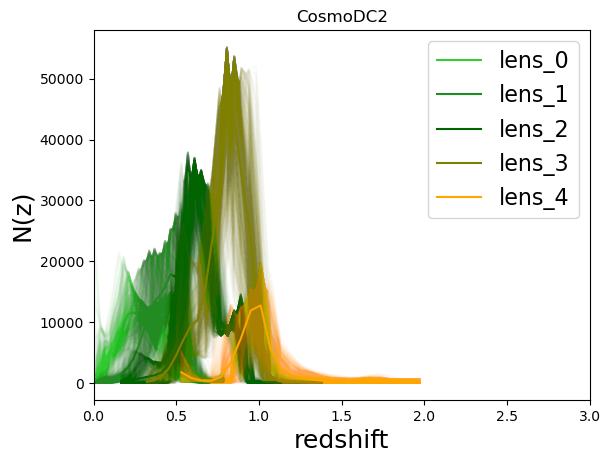

In [25]:
colors = ['limegreen', 'forestgreen', 'darkgreen', 'olive', 'orange']
for i, key in enumerate(list(lenses.keys())):
    tomo = lenses[key]
    photo_dz = np.mean(np.diff(tomo['znodes']))
    spec_dz = np.mean(np.diff(zgrid))
    alpha = photo_dz/spec_dz
    #plt.plot(tomo['spec_znodes'], alpha*tomo['spec_hist'], 'k-')
    plt.plot(tomo['znodes'], tomo['photo_hists'], '-', color=colors[i], alpha=0.01)
    plt.plot(tomo['znodes'], np.mean(tomo['photo_hists'], axis=1), '-', color=colors[i], label=key)

#nzsum = np.sum(fz_df['pdf'])
#plt.plot(zgrid,nzsum,c='b',label=f"i<{magcut} sum p(z)")

plt.xlim([0.0, 3.0])
plt.title("CosmoDC2")
plt.xlabel("redshift",fontsize=18)
plt.ylabel("N(z)",fontsize=18)
plt.legend(loc = 'upper right',fontsize=16);
plt.show()